In [1]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy.linalg import norm
from collections import namedtuple
from PIL import ImageGrab, Image
import sys
%matplotlib inline

In [2]:
def rgbImg(img):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def grayImg(img):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gray2rgb(img):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)


def getImg(path):
    img = cv2.imread(path)
    if img is None:
        raise RuntimeError('Can not read img from the path.')
    return img

def get_screenshot():
    printscreen_pil = ImageGrab.grab()
    return np.array(printscreen_pil.getdata(),dtype='uint8').reshape((printscreen_pil.size[1],printscreen_pil.size[0],3))

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (_cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return _cnts, boundingBoxes

def get_boxing_point(cnt):
    min_rect = cv2.minAreaRect(cnt)
    box = np.int0(cv2.cv.BoxPoints(min_rect))
    rec_sum = box.sum(axis=1)
    point1 = box[np.argmin(rec_sum)]
    point2 = box[np.argmax(rec_sum)]
    return point1-1, point2+1

def get_boxing_point2(cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    point1 = (x, y)
    point2 = (x+w, y+h)
    return point1, point2

def get_segment(text_img):
    seg_list = []
    _copy = text_img.copy()
    cnts, hierarchy = cv2.findContours(
        _copy, 
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    cnts, boxes = sort_contours(cnts)

    for i, c in enumerate(cnts):
        img_copy = text_img.copy()
        point1, point2 = get_boxing_point2(c)
        print point1, point2

        img_copy = text_img.copy()
        rgb_copy = gray2rgb(img_copy)
        cv2.rectangle(rgb_copy, tuple(point1), tuple(point2), (0,255,0), 1)
        plt.imshow(rgb_copy)
        plt.show()

        img_copy = text_img.copy()
        seg = img_copy[point1[1]:point2[1], point1[0]:point2[0]]
        seg_list.append(seg)
        plt.imshow(seg,'gray')
        plt.show()
    return seg_list

def resize(img, size):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    elif not isinstance(size, tuple):
        raise TypeError('Input size type is not tuple.')
    elif len(size) > 2 or len(size)< 2:
        raise ValueError('Input size is invalid.')
        
    output = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    plt.imshow(output, "gray")
    plt.show()
    return output


def convert2vector(seg_list):
    data_list = []
    
    for seg_img in seg_list:
        res_img = resize(seg_img,(20,20))
        #gray = grayImg(res_img)
        gray = res_img

        gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        _bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = _bin[:10,:10], _bin[10:,:10], _bin[:10,10:], _bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        data_list.append(hist)
    dataMat = np.array(data_list, np.float32)
    return dataMat


def prediction(testDataMat):
    #dic = {'11':'blank', '12':'dot', '13':'minus', '14':'um'}
    dic = {'11':'', '12':'.', '13':'-', '14':''}
    result = None
    output = ''
    svm = cv2.SVM()
    svm.load('D:\\OCR_working_space\\AOI\\OCR_model\\OCR_model2')
    response = svm.predict_all(testDataMat)
    print response
    for i, res in enumerate(response[::-1]):
        if dic.has_key(str(int(res[0]))):
            result = dic[str(int(res[0]))]
        else:
            result = str(int(res))
        output = output + result
    print output 
    return output

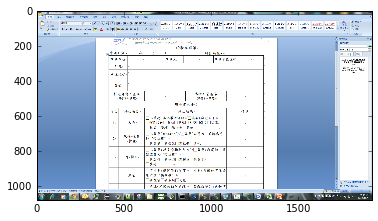

In [3]:
desktop = get_screenshot()
plt.imshow(desktop)
plt.show()

In [149]:
path = "D:\\OCR_working_space\\XRF\\XRF3.png"
save_path = "D:\\OCR_working_space\\XRF\\"

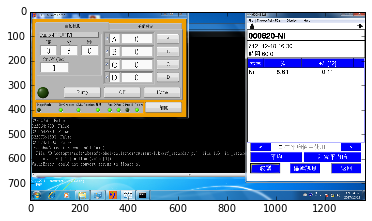

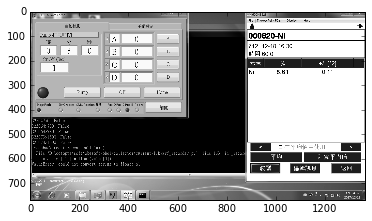

In [150]:
img = getImg(path)
rgb_img = rgbImg(img)
plt.imshow(rgb_img)
plt.show()

gray_img = grayImg(img)
plt.imshow(gray_img, 'gray')
plt.show()

In [151]:
ntp = namedtuple("img_slice", ("x_start","x_end", "y_start", "y_end"))

In [152]:
# [231:265,884:1350] ==> target windows
# [231:265,884:951] ==> ele windows
# [231:265,952:1104] ==> percent windows
# [231:265,1105:1315] ==> std windows

slice_list = []

ele_slice = ntp(884, 951, 231, 265)
slice_list.append(("ele", ele_slice))


pert_slice = ntp(952, 1104, 231, 265)
slice_list.append(("percent",pert_slice))

std_slice = ntp(1105, 1315, 231, 265)
slice_list.append(("std",std_slice))

print slice_list

[('ele', img_slice(x_start=884, x_end=951, y_start=231, y_end=265)), ('percent', img_slice(x_start=952, x_end=1104, y_start=231, y_end=265)), ('std', img_slice(x_start=1105, x_end=1315, y_start=231, y_end=265))]


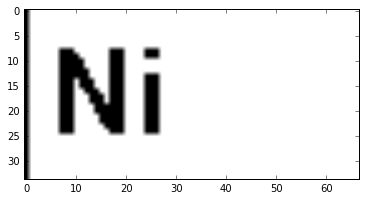

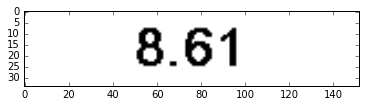

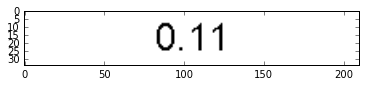

In [179]:
text_list = []
for name, img_slice in slice_list:
    _slice = gray_img[
            img_slice.y_start:img_slice.y_end,
            img_slice.x_start:img_slice.x_end
        ]

    ret, bin_img = cv2.threshold(_slice, 127, 255, cv2.THRESH_BINARY)
    #ret, bin_img = cv2.threshold(_slice, 127, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(bin_img, 'gray')
    plt.show()
    
    #dil_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (1,3))
    #dst = cv2.dilate(bin_img, dil_kernel)
    
    #ero_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (1,3))
    #bin_img = cv2.erode(bin_img, ero_kernel)
    
    #plt.imshow(dst, 'gray')
    #plt.show()
    
    
    text_list.append(bin_img)
    for i, _img in enumerate(text_list):
        cv2.imwrite(save_path+"text_{}.jpg".format(i), _img)


(1, 1) (66, 33)


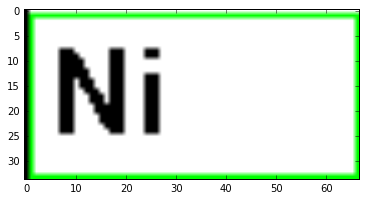

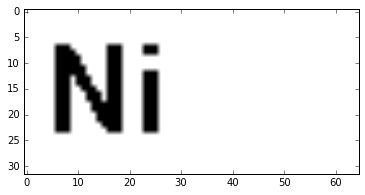

(1, 1) (151, 33)


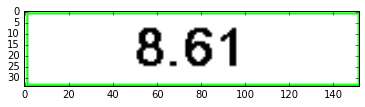

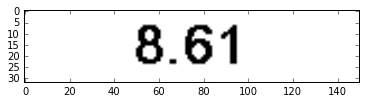

(1, 1) (209, 33)


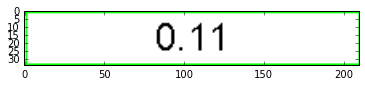

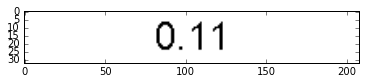

In [167]:
text_seg_list=[]

for text in text_list:
    seg_list = get_segment(text)
    text_seg_list.append(seg_list)

In [185]:
import pyocr
import pyocr.builders

tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("No OCR tool found")
    sys.exit(1)
# The tools are returned in the recommended order of usage
tool = tools[0]
print("Will use tool '%s'" % (tool.get_name()))
# Ex: Will use tool 'libtesseract'

langs = tool.get_available_languages()
print langs
print("Available languages: %s" % ", ".join(langs))
lang = langs[0]
print("Will use lang '%s'" % (lang))
# Ex: Will use lang 'fra'
# Note that languages are NOT sorted in any way. Please refer
# to the system locale settings for the default language
# to use.

Will use tool 'Tesseract (sh)'
[u'eng', u'osd']
Available languages: eng, osd
Will use lang 'eng'


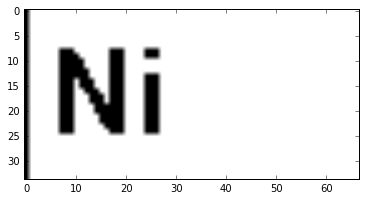

Ans: Ni


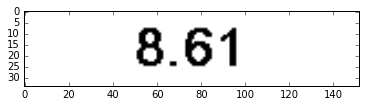

Ans: 8.61


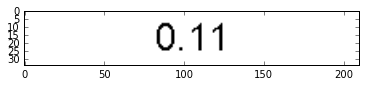

Ans: 0.11


In [186]:
for text in text_list:
    plt.imshow(text, "gray")
    plt.show()
    
    #cv2.imshow('text', text)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    image = Image.fromarray(text)
    #print image
    txt = tool.image_to_string(
    image,
    lang=lang, #'wid',
    builder=pyocr.builders.DigitBuilder()
    )
    # txt is a Python string
    print "Ans:", txt

In [176]:
help(pyocr.builders)

Help on module pyocr.builders in pyocr:

NAME
    pyocr.builders - Builders: Each builder specifies the expected output format

FILE
    c:\users\160619\appdata\local\continuum\anaconda2\lib\site-packages\pyocr-0.4.7-py2.7.egg\pyocr\builders.py

DESCRIPTION
    raw text : TextBuilder
    words + boxes : WordBoxBuilder
    lines + words + boxes : LineBoxBuilder

CLASSES
    __builtin__.object
        Box
        LineBox
    BaseBuilder(__builtin__.object)
        LineBoxBuilder
            DigitLineBoxBuilder
        TextBuilder
            DigitBuilder
        WordBoxBuilder
    
    class Box(__builtin__.object)
     |  Boxes are rectangles around each individual element recognized in the
     |  image. Elements are either char or word depending of the builder that
     |  was used.
     |  
     |  Methods defined here:
     |  
     |  __eq__(self, other)
     |  
     |  __ge__(self, other)
     |  
     |  __gt__(self, other)
     |  
     |  __hash__(self)
     |  
     |  __init

In [21]:
li = [[1,2], [3,4], [5,6],[]]

In [27]:
sli = [str(ele) for li_ele in li for ele in li_ele] #[次元素 主疊代 次疊代]

In [28]:
'.'.join(sli)

'1.2.3.4.5.6'

In [145]:
s1 = '{"as":1}'
s2 = "{'as':1}"
s = "\"".join(s2.split("\'"))

In [146]:
import json
print json.loads(s1)

{u'as': 1}


In [127]:
from ast import literal_eval
print literal_eval(s1)
print literal_eval(s2)
help(literal_eval)

{'as': 1}
{'as': 1}
Help on function literal_eval in module ast:

literal_eval(node_or_string)
    Safely evaluate an expression node or a string containing a Python
    expression.  The string or node provided may only consist of the following
    Python literal structures: strings, numbers, tuples, lists, dicts, booleans,
    and None.



In [108]:
def json_parse():
    string = "{'as':1}"
    s = "\"".join(string.split("'"))
    return json.loads(s)

def ast_parse():
    string = "{'as':1}"
    return literal_eval(s)

In [92]:
import timeit

In [93]:
timeit.timeit(json_parse)

4.874653691834624

In [109]:
timeit.timeit(ast_parse)

14.304985526186101

In [189]:
18%19

18